# E-commerce Sample ETL – October

This notebook prepares a 100 k-row sample for loading into BigQuery.

Pipeline steps:
1. Data profiling  
2. Schema enforcement & typing  
3. Cleaning & imputation  
4. De-duplication & filtering  
5. Feature engineering & enrichment  
6. Validation tests  
7. **Export cleaned sample to CSV**

In [4]:
# 0️⃣ Imports & settings
import pandas as pd
pd.set_option("display.max_columns", 120)

INPUT_PATH = "D:\Digital_Analytics\sample_Oct.csv"
CSV_OUT    = "D:\Digital_Analytics\Cleaned data\Cleaned_Oct.csv"

## 1  Data profiling

In [5]:
df = pd.read_csv(INPUT_PATH, parse_dates=["event_time"], low_memory=False)
print(f"Rows: {len(df):,}")
df.info()

# basic statistics
display(df.describe().T)

# null counts
display(df.isna().sum().sort_values(ascending=False))

# cardinality for object/category columns
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
display(pd.Series({c: df[c].nunique() for c in cat_cols}).sort_values(ascending=False))

Rows: 100,000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     100000 non-null  datetime64[ns, UTC]
 1   event_type     100000 non-null  object             
 2   product_id     100000 non-null  int64              
 3   category_id    100000 non-null  int64              
 4   category_code  67605 non-null   object             
 5   brand          85741 non-null   object             
 6   price          100000 non-null  float64            
 7   user_id        100000 non-null  int64              
 8   user_session   100000 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 6.9+ MB


,count,mean,std,min,25%,50%,75%,max
product_id,100000.0,1.021692e+07,1.110482e+07,1.001588e+06,1.005116e+06,5.100564e+06,1.590011e+07,5.310002e+07
category_id,100000.0,2.056068e+18,1.485811e+16,2.053014e+18,2.053014e+18,2.053014e+18,2.053014e+18,2.175420e+18
price,100000.0,2.870277e+02,3.599017e+02,0.000000e+00,6.152000e+01,1.544100e+02,3.572500e+02,2.574070e+03
user_id,100000.0,5.310936e+08,1.662104e+07,3.064418e+08,5.156360e+08,5.269756e+08,5.477189e+08,5.555060e+08


category_code    32395
brand            14259
event_time           0
event_type           0
product_id           0
category_id          0
price                0
user_id              0
user_session         0
dtype: int64

user_session     24984
brand             1503
category_code      123
event_type           3
dtype: int64

## 2  Schema enforcement & typing

In [6]:
schema = {
    "timestamp": "datetime64[ns]",
    "user_id"  : "Int64",
    "session_id": "string",
    "event_type": "category",
    "product_id": "string",
    "price"     : "float64",
    "quantity"  : "Int64"
}

df.columns = df.columns.str.lower().str.replace(" ", "_")

for col, dtype in schema.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)

## 3  Cleaning & imputation

In [7]:
# drop exact duplicates
df = df.drop_duplicates()

# handle missing values (drop if <5 %, else fill)
threshold = 0.05 * len(df)
for col in df.columns:
    n_missing = df[col].isna().sum()
    if n_missing == 0:
        continue
    if n_missing < threshold:
        df = df[df[col].notna()]
    else:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna("unknown")

## 4  De-duplication & filtering

In [8]:
# business-rule example: keep last event per session
if "session_id" in df.columns:
    df = df.sort_values("timestamp").drop_duplicates("session_id", keep="last")

# logical filters
if "price" in df.columns:
    df = df[df["price"] >= 0]
if "quantity" in df.columns:
    df = df[df["quantity"] >= 0]

## 5  Feature engineering & enrichment

In [10]:
if "event_type" in df.columns:
    df["is_purchase"] = df["event_type"] == "purchase"

df["hour_of_day"] = df["event_time"].dt.hour
df["day_of_week"] = df["event_time"].dt.dayofweek
df["is_weekend"]  = df["day_of_week"].isin([5, 6])

# optional: session duration
if "session_id" in df.columns:
    span = (
        df.groupby("session_id")["timestamp"]
          .agg(["min", "max"])
          .assign(duration_s=lambda x: (x["max"] - x["min"]).dt.total_seconds())
    )
    df = df.merge(span["duration_s"], left_on="session_id", right_index=True, how="left")

## 6  Validation tests

In [11]:
assert df["price"].min() >= 0, "Negative prices detected"
if 'quantity' in df.columns:
    assert df['quantity'].min() >= 0, "Negative quantities detected!"
if "duration_s" in df.columns:
    assert (df["duration_s"] >= 0).all(), "Negative session durations"

print("✅ All validation checks passed.")

✅ All validation checks passed.


## 7  Export cleaned sample to **CSV**

In [12]:
df.to_csv(CSV_OUT, index=False)
print(f"Saved → {CSV_OUT}")

Saved → D:\Digital_Analytics\Cleaned data\Cleaned_Oct.csv


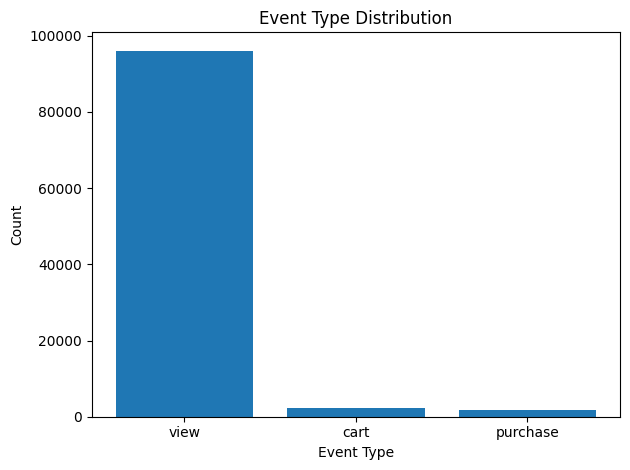

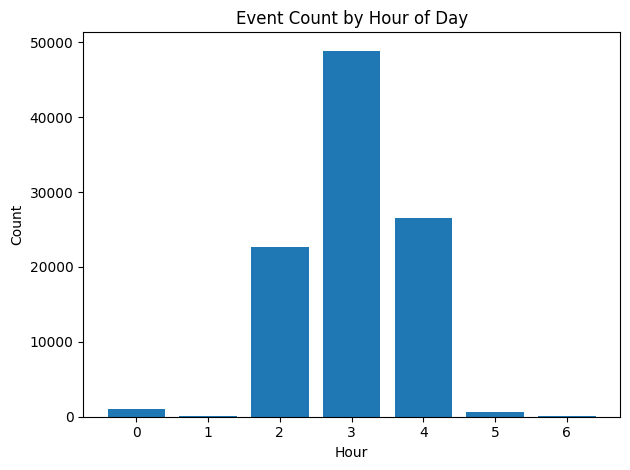

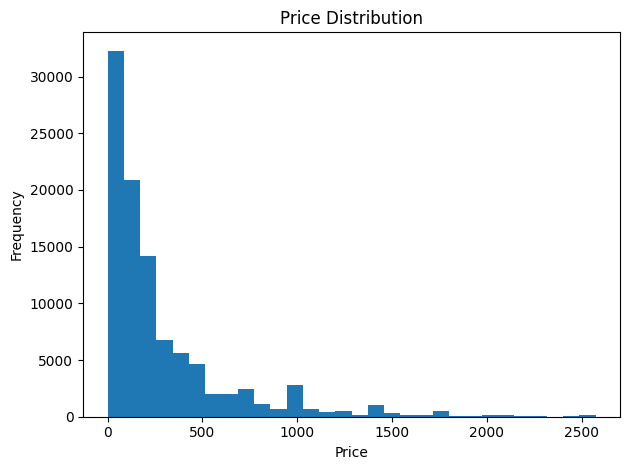

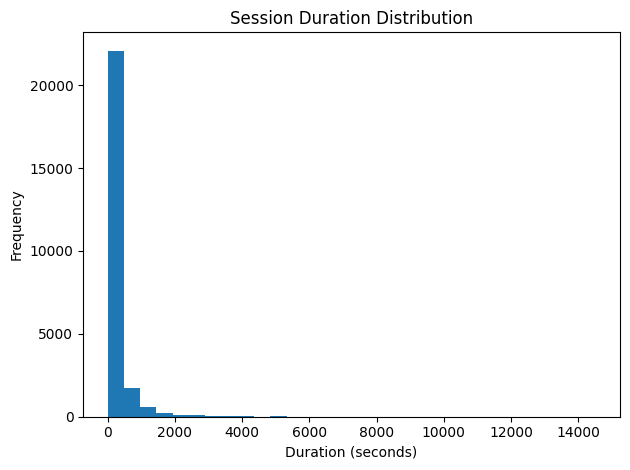

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 0️⃣ Load cleaned sample data (adjust path if necessary)
INPUT_PATH = 'D:\Digital_Analytics\sample_Oct.csv'
df = pd.read_csv(INPUT_PATH, parse_dates=['event_time'])

# 1️⃣ Event Type Distribution
event_counts = df['event_type'].value_counts()
plt.figure()
plt.bar(event_counts.index.astype(str), event_counts.values)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Event Count by Hour of Day
hours = df['event_time'].dt.hour
hour_counts = hours.value_counts().sort_index()
plt.figure()
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Event Count by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3️⃣ Price Distribution
plt.figure()
plt.hist(df['price'].dropna(), bins=30)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 5️⃣ Session Duration Distribution
session_span = df.groupby('user_session')['event_time'].agg(['min', 'max'])
session_span['duration_s'] = (session_span['max'] - session_span['min']).dt.total_seconds()
plt.figure()
plt.hist(session_span['duration_s'].dropna(), bins=30)
plt.title('Session Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
